# EXTRACT-public demo notebook

[EXTRACT]() is a MATLAB processing toolkit.

After saving results into a `h5` file, we load results in this notebook to analyze.

``` python

# EXAMPLE: Access the outputs like a dictionary
spatial_weights = outputs["spatial_weights"]
temporal_weights = outputs["temporal_weights"]
info = outputs["info"]
config = outputs["config"]

max_image = info['max_image']
f_pixel = info["F_per_pixel"]
summary = info["summary"]
summary_image = info["summary_image"]

```

In [60]:
import h5py
from pathlib import Path
import numpy as np
import mbo_utilities as mbo

### Functions

- load outputs
- plot cell masks

In [ ]:
def plot_output_masks(output, clim_scale=(0, 0.95), title=""):
    """Python version of [EXTRACT-plot_output_cells]"""
    info = output['info']
    summary_image = info['summary_image']
    spatial_weights = output['spatial_weights']
    spatial_weights = np.moveaxis(spatial_weights, 0, -1)

    vmin, vmax = np.quantile(summary_image, clim_scale)
    plt.imshow(summary_image, cmap=get_cmap("gray"), vmin=vmin, vmax=vmax)
    plt.axis("image")

    n_cells = spatial_weights.shape[-1]
    cmap = plt.get_cmap("tab10")

    for i in range(n_cells):
        mask = spatial_weights[..., i] > 0
        color = cmap(i % 10)
        plt.contourf(mask.astype(float), levels=[0.5, 1], colors=[color], alpha=1)

    plt.ylabel(f"# output cells: {n_cells}", fontsize=14)
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

def load_extract_outputs_h5(filepath):
    def read_group(h5grp):
        out = {}
        for key, item in h5grp.items():
            if isinstance(item, h5py.Group):
                out[key] = read_group(item)
            elif isinstance(item, h5py.Dataset):
                data = item[()]
                if isinstance(data, bytes):
                    data = data.decode("utf-8")
                out[key] = data
        return out

    with h5py.File(filepath, 'r') as f:
        outputs = {
            'spatial_weights': f['/spatial_weights'][()],
            'temporal_weights': f['/temporal_weights'][()],
            'info': read_group(f['/info']),
            'config': read_group(f['/config']),
        }
    return outputs

## First parameter set

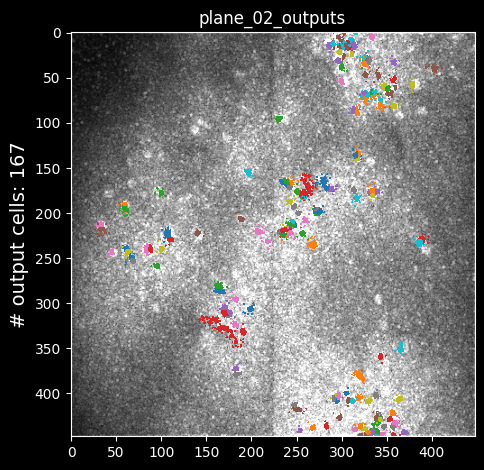

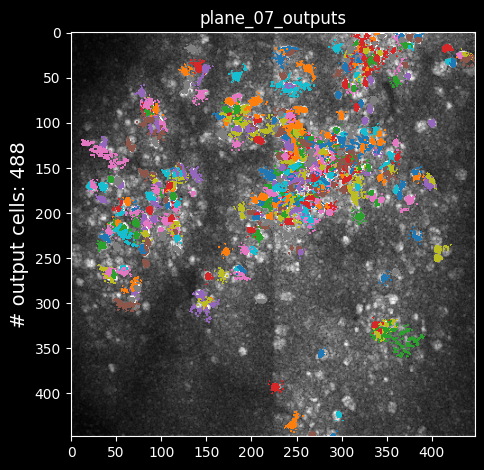

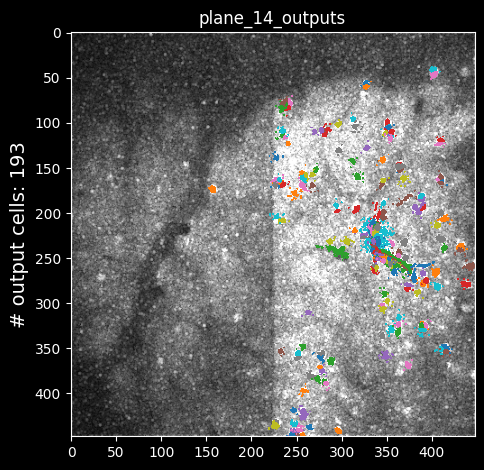

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract", 'h5', 2)
for f in files:
    outputs = load_extract_outputs_h5(f)
    plot_output_masks(output=outputs, title=Path(f).stem)
    plt.show()

## Second parameter set

In [ ]:
files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract", 'h5', 2)
fpath = r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract\plane_02_outputs.h5"
outputs = load_extract_outputs_h5(fpath)

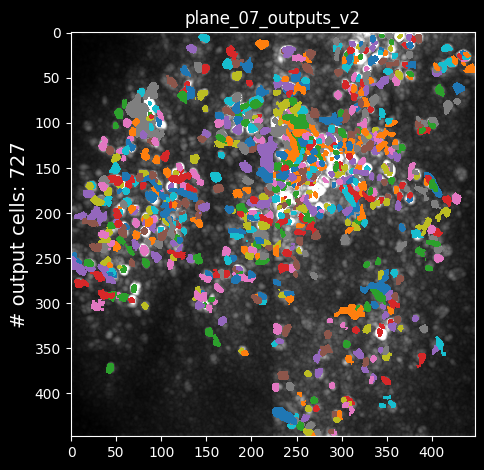

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

files = mbo.get_files(r"D:\W2_DATA\kbarber\2025_03_01\assembled\extract_v2", 'h5', 2)
for f in files:
    outputs = load_extract_outputs_h5(f)
    plot_output_masks(output=outputs, title=Path(f).stem)
    plt.show()